# Hands-On Machine Learning

## Session 4: Evaluation, Validation and Model Assessment
by Laxmi Gupta, Christoph Haarburger

### Goals of this Session

In this session you will...
* learn to assess a model's performance
* get to know the most common evaluation measures
* learn how to tune a model's hyperparameters

### Iris Dataset

You already know the Iris dataset from you first session. Anyway, here's a quick recap: The dataset consists of three species (=classes) of the Iris plant (Setosa, Versicolor and Virginica). For each sample, four features have been measured (sepal length, sepal width, petal length, petal width). 

The goal ist to train a model that can classify a given sample into one of the three species. Based on your knowledge of classifiers from the 1st session, today we'll focus more on the evaluation of performance and tuning of hyperparameters rather than the classifier itself.

In [239]:
%matplotlib inline

In [240]:
import seaborn as sns
from evaluation import load_iris
data = load_iris()

Before training any kind of model it is always a good idea to make ourselves familiar with the raw data and explore basic properties of the dataset. The dataset has already been loaded as a `pandas.DataFrame` which is a very handy data type for our exploration.

In [241]:
data[:15]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


You my find it interesting to look at the raw numbers, but with our goal of building a classifier in mind we particularly want to explore statistical properties of the dataset.

In [242]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


**Task**: Find out if the prevalence of the three classes is equal!

In [243]:
import numpy as np
y = data['species'].values # turn pandas.DataFrame into np.ndarray
occ = np.unique(y, return_counts=True)
print(occ)

(array(['setosa', 'versicolor', 'virginica'], dtype=object), array([50, 50, 50]))


We're lucky, all classes are represented in equal ratios 😅.

If the number of features is relatively small as in our case, it is also a good idea to plot features pairswise against each other and inspect the feature scores for all classes as histograms.

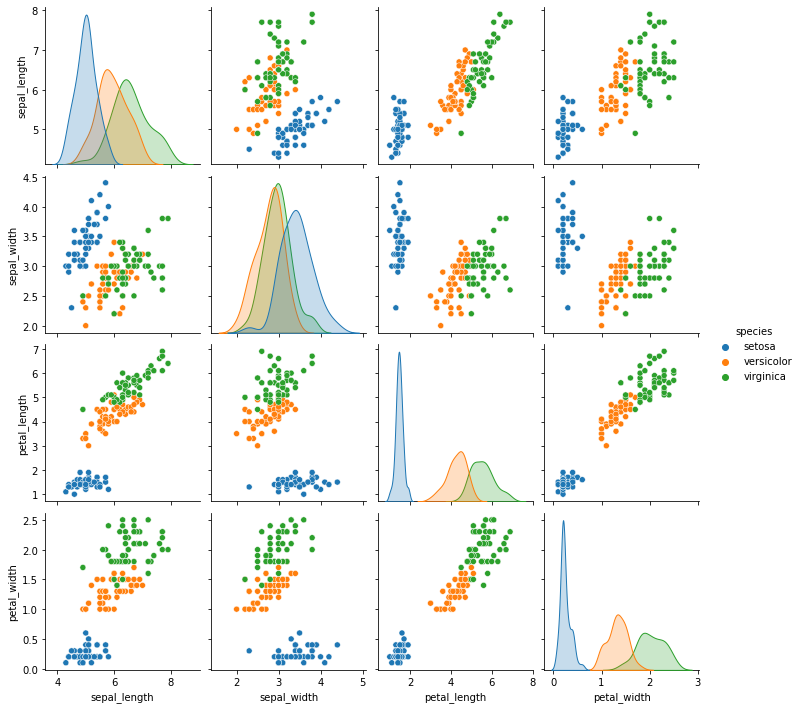

In [244]:
_ = sns.pairplot(data, hue='species')

**Task:** Can the classification problem be solved by a linear classifier?

**Answer:** 

Various features have a clear boundary. Therefore, we can easily separate the samples into three classes using two hyperplanes defined through a linear classifier.

Now that we have gained some intuitution on the problem to be solved und the underlying data, let's get to what we are actually up to: Classification! As a first shot, it is always a good idea to utilize a classifier that is easy to understand and easy to interpret. K-Nearest-Neighbors does the job...

In [245]:
from sklearn.neighbors import KNeighborsClassifier as KNN

X = np.array(data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values)
y = np.array(y)

# .as_matrix() has been deprecated used .values instead to turn pandas.DataFrame into np.ndarray

model = KNN(n_neighbors=2)
model.fit(X, y)
y_pred = model.predict(X)

**Task:** To interpret the result, implement the accuracy measure and calculate the accuracy for our predictions. Accuracy is defined as $\frac{\mathrm{true}_\mathrm{positive} + \mathrm{true}_\mathrm{negative}}{\mathrm{positive} + \mathrm{negative}}$.

In [246]:
# print(y_pred == y)

def accuracy_score(y_true, y_pred):
    tp = sum(y_pred == y_true)
    acc = tp / len(y_true)
    return acc

accuracy_score(y, y_pred)

0.98

**Task:** Why is the classification accuracy nearly perfect? 

**Answer:**

We use training and test data interchangeably and our model simply averages the nearest neighbors from our sample points.

## Holdout Sets

A much better way to evaluate performance is to split all available data into a training and test set, where the training set is used for training the model's parameters and the test set is utilized for assessing performance. 

**Task:** Implement the same pipeline as in the last code cell but with a separate training and test set (50/50)!

In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)


model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

# print(y_test_pred)
# print(y_test)

acc = accuracy_score(y_test_pred, y_test)
print(acc)

0.8933333333333333


That looks a lot more realistic! 

**Task:** When using `train_test_split`, the samples are *randomly* drawn to one of the sets. What happens, if we use a different split? Determine the 95% confidence intervals for random 100 splits. *Hint:* `np.percentile`

In [248]:
acc_scores = []

for num_iter in range(100):

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.50)
    
    model.fit(X_train_p, y_train_p)
    y_test_pred_p = model.predict(X_test_p)

    acc = accuracy_score(y_test_pred_p, y_test_p)
    
    acc_scores.append(acc)

np.percentile(np.array(acc_scores), 95)

0.9733333333333334

**Task:** What properties should a 'good' split have with respect to the dataset?

**Answer:**

The training set should be large enough to train the model. Test set should avoid high feature variance compared to the training set.

## Cross Validation

One disadvantage of the holdout set method is that half the dataset does not contribute to the training of the model. Especially if the initial set of training data is small this is suboptimal since statistical learning methods tend to perform worse when trained on fewer observations.

In cross validation we can overcome this by partitioning the data set in `k` "folds" of approximately equal size. The first fold is used as a test set and the model is trained on the remaining `k` - 1 folds. The test error is then computed on the test set and the process is repeated `k` times, resulting in `k` estimates of the test error.

**Task:** Implement the `CrossValidation` class as sketched in the following cell! 
Hint: This is advanced task that is not mandatory to be solved.

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

class CrossValidation(object):
    
    def __init__(self, model, k):
        self.model = model
        self.k = k
        self.k_size = int(len(X_train) / k)

    
    def evaluate(self, X_train, y_train, X_test, y_test):

        acc_val_mean = []
        acc_test_mean = []
        
        for k_idx in range(0, len(X_train), self.k_size):
            X_train_k = np.concatenate((X_train[:k_idx], X_train[k_idx + k_size:]))
            y_train_k = np.concatenate((y_train[:k_idx], y_train[k_idx + k_size:]))
            X_valid_k = X_train[k_idx:(k_idx + k_size)]
            y_valid_k = y_train[k_idx:(k_idx + k_size)]

            # print(y_train_k.shape)
            # print(X_train_k.shape)

            self.model.fit(X_train_k, y_train_k)
            y_valid_k_pred = model.predict(X_valid_k)

            acc_val = accuracy_score(y_valid_k, y_valid_k_pred)
            acc_val_mean.append(acc_val)
        
            y_test_k_pred = model.predict(X_test)
            acc_test = accuracy_score(y_test, y_test_k_pred)
            acc_test_mean.append(acc_test)
        
        mu_val = sum(acc_val_mean) / len(acc_val_mean)
        mu_test = sum(acc_test_mean) / len(acc_test_mean)
        
        return mu_val, mu_test

**Task:** Use the `CrossValidation` class to evaluate the test error of the same KNN model as above but with 10 fold cross validation. What's the mean test error? If you did not solve the previous task on your own, you can use `KFold` from `scikit-learn`.

In [250]:
cross_val = CrossValidation(model, 10)
acc = cross_val.evaluate(X, y, X_test, y_test)
error = 1 - np.array(acc)

print(f"{error[0]}")

0.06666666666666643


**Task:** Why did the accuracy improve compared to the holdout split? What's a disadvantage of the cross validation approach?

**Answer:**

By using k-fold cross validation a larger training set is used. Due to the lower validation set the variance increases.

## Hyperparameter Optimization

KNN is well known for being easy to use and interpret, howerever to achieve top performance it is not the best choice. In the first Session you got to know the Support Vector Machine (SVM) classifier. In contrast to KNN it has quite a few hyperparameters that need to optimized to achieve top performance. In the next few steps we will optimize SVM hyperparameters by a grid search.

SVMs are not scale invariant, i.e. all features need to be scaled to the same range, for example [-1, 1] or [0, 1]. The most common approach to this is the subtraction of the mean and division by the standard deviation of each feature.

It is one of the most common errors in machine learning to carry out scaling on the whole dataset rather than on training- and test set independently. If this is not considered, information about the distribution of the test set (mean and standard deviation) leaks into the training set and the cross validation is flawed.

A very handy way to overcome this is using the `sklearn.pipeline.Pipeline` class for combining consecutive processing pipelines such as scaling and classification.

**Task:** Combine an SVM classifier (default parameters) and a `StandardScaler` in a `Pipeline`. 

In [251]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.92

If you now call `pipe.fit(X_train, y_train)`, the pipeline calculcates mean and standard deviation based on the training data, applies the scaling and trains the SVM.

It's time to tune the SVM's hyperparameters, namely the `C` parameter, the type of kernel and the `gamma` parameter.
The naive approach to hyperparameter tuning lies in exhaustively testing all possible combinations of parameters, which is called grid search. 

**Task:** Implement a parameter grid for our three parameters to tune and perform the grid search in a 10-fold cross validation!

**Hint:** Keep in mind that exhaustive grid search results in high computation times. Use parallelization with the `n_jobs` argument and keep track of time with the `%time` magic command.

In [252]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# k_fold = KFold(n_splits=10)

%time

gcv = GridSearchCV(pipe, 
                   param_grid={'svc__C': [0.1, 0.5, 1, 5, 10], 'svc__gamma': ('scale', 'auto'), 'svc__kernel': ('linear', 'rbf')}, cv=10, n_jobs=8)

gcv.fit(X_train, y_train)
y_pred = gcv.predict(X_test)

# print(y_pred)

acc = accuracy_score(y_test, y_pred)

print(acc)
# print(gcv.cv_results_)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs
0.9466666666666667


Take a closer look at the grid search results. What mean test score can you achieve?

In [253]:
from evaluation import show_grid_search_results
show_grid_search_results(gcv)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,0.001984,0.000706,0.000835,0.000432,1,auto,linear,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.0,1.0,...,1.0,1.0,1.0,0.857143,1.0,0.857143,1.0,0.971429,0.057143,1
4,0.002142,0.000723,0.001126,0.001423,0.5,scale,linear,"{'svc__C': 0.5, 'svc__gamma': 'scale', 'svc__k...",1.0,1.0,...,1.0,1.0,1.0,0.857143,1.0,0.857143,1.0,0.971429,0.057143,1
14,0.001958,0.001130,0.000570,0.000136,5,auto,linear,"{'svc__C': 5, 'svc__gamma': 'auto', 'svc__kern...",1.0,1.0,...,1.0,1.0,1.0,0.857143,1.0,0.857143,1.0,0.971429,0.057143,1
6,0.002358,0.000555,0.001556,0.001415,0.5,auto,linear,"{'svc__C': 0.5, 'svc__gamma': 'auto', 'svc__ke...",1.0,1.0,...,1.0,1.0,1.0,0.857143,1.0,0.857143,1.0,0.971429,0.057143,1
8,0.002056,0.000870,0.000780,0.000258,1,scale,linear,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.0,1.0,...,1.0,1.0,1.0,0.857143,1.0,0.857143,1.0,0.971429,0.057143,1


As the number of hyperparameter is usually much higher than here, a naive grid search is often not feasible in practice. A good alternative lies in a randomized search, in which the parameter space is sampled coarsely.

**Task:** Implement the same workflow as above withe the same parameter range but using `RandomizedSarchCV`. Can you achieve comparable performance in shorter time?

In [254]:
from sklearn.model_selection import RandomizedSearchCV

%time

gcv = RandomizedSearchCV(pipe, 
                   param_distributions={'svc__C': [0.1, 0.5, 1, 5, 10], 'svc__gamma': ('scale', 'auto'), 'svc__kernel': ('linear', 'rbf')}, cv=10, n_jobs=8, n_iter=2)

gcv.fit(X_train, y_train)
y_pred = gcv.predict(X_test)

# print(y_pred)

acc = accuracy_score(y_test, y_pred)

print(acc)



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
0.9466666666666667


You probably found out that it is possible to achieve literally the same mean test score using a randomizes search in just the fraction of the time needed for al full grid search.

**Task:** Is the mean test score a good estimation of the performance we can expect on unseen data?

**Answer:**

Depending on the number of iterations through the randomized grid search the accuracy will be similar to a full grid search that finds the optimal parameters.

## Evaluation Measures

To make this more interesting, the iris dataset was slightly modified to better resemble real-world datasets. The following modified Iris dataset is smaller, there are only two classes present and the prevalence for the two classes is imbalanced.

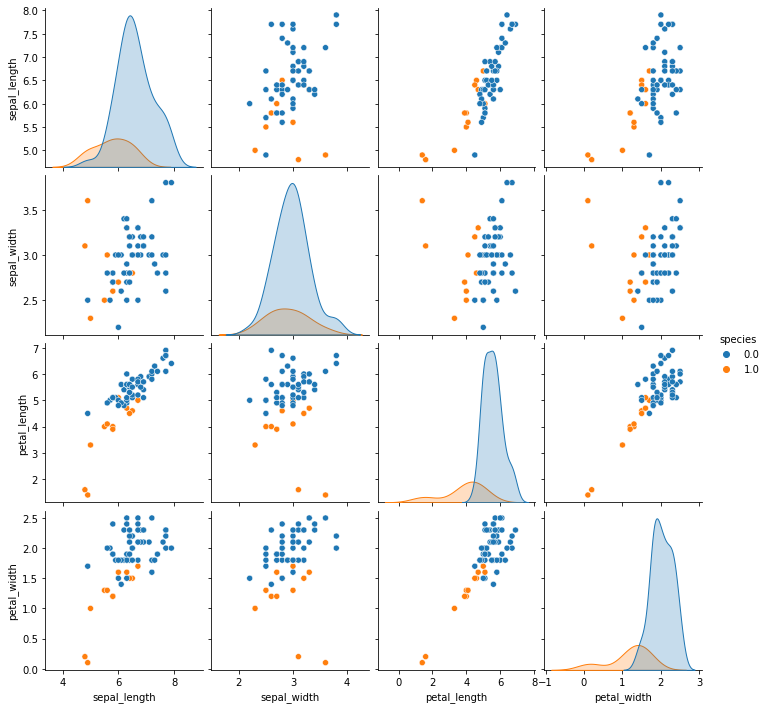

In [255]:
data = load_iris(imbalanced_binary=True)
_ = sns.pairplot(data, hue='species', vars=data.columns[:-1])

**Task:** Solve the binary classification problem by a KNN classifier, optimize the number of neighbors by 5 fold cross validation and evaluate accuracy on the test set using the best `n_neighbors`. 

[0.8428571428571429, 0.8714285714285716, 0.8428571428571429, 0.8714285714285716, 0.8714285714285716, 0.8714285714285716, 0.8714285714285716, 0.8714285714285716, 0.8714285714285716, 0.7714285714285715, 0.8047619047619048, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047, 0.7047619047619047]


0.967741935483871

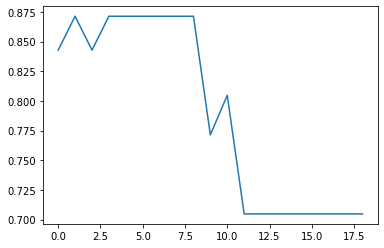

In [256]:
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(np.array(data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values), np.array(data[['species']].values).flatten(), test_size=0.5, random_state=1)

k_fold = KFold(n_splits=5)

accuracy = []

for i in range(1, 20):
    temp = [KNN(n_neighbors=i).fit(X_train[train], y_train[train]).score(X_train[test], y_train[test]) for train, test in k_fold.split(X_train)]
    accuracy.append(np.mean(temp))

print(accuracy)
plt.plot(accuracy) # best nearest neighbors equal to 2

model_KNN = KNN(n_neighbors=2)
model_KNN.fit(X_train, y_train)
y_pred_KNN = model_KNN.predict(X_test)
accuracy_score(y_pred_KNN, y_test)


Not too bad. You probably achieved an accuracy near 90%. After this first result we should take a more detailed look at the performance using a confusion matrix, i.e. find out the number of true positives, true, negatives, false positives and false negatives.

In [257]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred_KNN))

print(y_test.flatten())

# dataset is inbalanced use equalization techniques

[[28  0]
 [ 1  2]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


Apparently, we only had four positive samples in the test set, out of which one half was classified incorrectly.

**Task:** What do you conclude about accuracy as a metric? Whats the accuracy of just labelling all samplese as negative?

In [258]:
y_zero = np.zeros((len(y_test)))

accuracy_score(y_test, y_zero)

0.9032258064516129

** Solution:**

### ROC Curves
A better way to assess classification performance for imbalanced problems lies in looking at the *true positive rate* and *false positive rate* (also known as sensitivity and specifity).

These two can even be plotted against each other, which results in a receiver operating curve (ROC). The higher the area under the ROC curve (AUC) the better the classifier.

This is especially useful in medical image processing, a context in which we usually have data from a population out of which a small fraction has a particular disease that need to be detected.

**Task:** Whats are the *true positive rate*, *false positive rate* and *AUC* of our classifier? Plot the ROC curve!

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1.]
[0.         0.66666667 1.        ]
0.8333333333333333


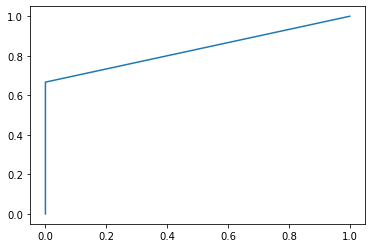

In [259]:
from sklearn.metrics import roc_auc_score, roc_curve

print(y_test)
print(y_pred_KNN)

# model_KNN.score(X_test, y_test)
# roc_auc_score(y_test, y_pred_KNN)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_KNN)

print(fpr)
print(tpr)

plt.plot(fpr, tpr)

area = roc_auc_score(y_test, y_pred_KNN)
print(area)

## Yayy, high accuracy!... Just by chance?

**Task:** What if we were to consider only two features for classification, which ones would you choose? Would the accuracy be 'significantly' different depending on the choice of features?  

In [260]:
import pandas as pd

df = pd.DataFrame(data=X_train)
df.corr()

,0,1,2,3
0,1.000000,0.169329,0.812832,0.698209
1,0.169329,1.000000,-0.128152,-0.065811
2,0.812832,-0.128152,1.000000,0.906489
3,0.698209,-0.065811,0.906489,1.000000


**Answer:**

Accuracy will probably only slightly vary. Correlation between features can be reduced by choosing features that are uncorrelated. Taking into consideration the data distributions in the evaluation metrics choosing sepal width and petal length is probably the most sensible solutions given the data at this point.

We will use the scipy.stats module for simple statistical tests.

In [261]:
from scipy import stats

## Student's t-test

Let us consider two feature groups and see if we get similar accuracies or not:
    1. only sepal length and petal length
    2. only sepal width and petal width

In [262]:
data = load_iris()
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
X_length = data[['petal_length', 'sepal_length']].values # Considering only lengths 
X_width = data[['sepal_width', 'petal_width']].values # Considering only widths

X_sepal = data[['sepal_width', 'sepal_length']].values # Considering only lengths 
X_petal = data[['petal_width', 'petal_length']].values # Considering only widths

y = data['species'].values

scores = np.zeros(100)
scores_length = np.zeros(100)
scores_width = np.zeros(100)
scores_sepal = np.zeros(100)
scores_petal = np.zeros(100)


# Calculate accuracy when considering all the features
for i in range(100):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.5)

    model = KNN(n_neighbors=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    scores[i] = accuracy_score(y_test, y_pred)
print('Mean accuracy considering all the features = {:2.3}'.format(scores.mean()))

# Calculate accuracy when considering only lengths
for i in range(100):    
    X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y, random_state=i, test_size=0.5)
    
    model = KNN(n_neighbors=2)
    model.fit(X_length_train, y_length_train)
    
    y_length_pred = model.predict(X_length_test)
    scores_length[i] = accuracy_score(y_length_test, y_length_pred)
print('Mean accuracy considering petal_length and sepal_length only = {:2.3}'.format(scores_length.mean()))

# Calculate accuracy when considering only widths
for i in range(100):    
    X_width_train, X_width_test, y_width_train, y_width_test = train_test_split(X_width, y, random_state=i, test_size=0.5)
    
    model = KNN(n_neighbors=2)
    model.fit(X_width_train, y_width_train)
    
    y_width_pred = model.predict(X_width_test)
    scores_width[i] = accuracy_score(y_width_test, y_width_pred)
print('Mean accuracy considering petal_width and sepal_width only = {:2.3}'.format(scores_width.mean()))



# Calculate accuracy when considering only sepal
for i in range(100):    
    X_sepal_train, X_sepal_test, y_sepal_train, y_sepal_test = train_test_split(X_sepal, y, random_state=i, test_size=0.5)
    
    model = KNN(n_neighbors=2)
    model.fit(X_sepal_train, y_sepal_train)
    
    y_sepal_pred = model.predict(X_sepal_test)
    scores_sepal[i] = accuracy_score(y_sepal_test, y_sepal_pred)
print('Mean accuracy considering sepal_width and sepal_length only = {:2.3}'.format(scores_sepal.mean()))


# Calculate accuracy when considering only petal
for i in range(100):    
    X_petal_train, X_petal_test, y_petal_train, y_petal_test = train_test_split(X_petal, y, random_state=i, test_size=0.5)
    
    model = KNN(n_neighbors=2)
    model.fit(X_petal_train, y_petal_train)
    
    y_petal_pred = model.predict(X_petal_test)
    scores_petal[i] = accuracy_score(y_petal_test, y_petal_pred)
print('Mean accuracy considering petal_width and petal_length only = {:2.3}'.format(scores_petal.mean()))



Mean accuracy considering all the features = 0.942
Mean accuracy considering petal_length and sepal_length only = 0.929
Mean accuracy considering petal_width and sepal_width only = 0.933
Mean accuracy considering sepal_width and sepal_length only = 0.722
Mean accuracy considering petal_width and petal_length only = 0.952


### 2-sample t-test: testing for difference across populations

The means of both the groups are different. To test if this is significant, we perform a 2-sample t-test with scipy.ttest_ind()

In [263]:
stats.ttest_ind(scores_length, scores_width)

Ttest_indResult(statistic=-1.1926689440344542, pvalue=0.23442635988265995)

If the observed p-value is smaller than the threshold value (typically 0.01, 0.05, 0.1), we reject the null hypothesis of equal means. In this case, however, we fail to find statistical difference.

**Task:** Are the groups X_petal and X_sepal significantly different from X?

In [264]:
print(stats.ttest_ind(scores, scores_sepal))
print(stats.ttest_ind(scores, scores_petal))

Ttest_indResult(statistic=43.44293824417406, pvalue=3.5228389041479695e-103)
Ttest_indResult(statistic=-3.5968669242974687, pvalue=0.00040675717941757026)


*Conclusion*

    X_petal is significantly different from X 
    X_sepal is significantly different from X 

### Paired t-test: repeated measurements

Note that the measurements for petal and sepal are made on the same flowers! In such a case where each subject is measured twice, we can use a paired sample t-test.

In [265]:
stats.ttest_rel(scores_length, scores_width)

Ttest_relResult(statistic=-1.3582048803087174, pvalue=0.17748587365840177)

Another thing we overlooked is the fact that t-tests assume a gaussian distribution of the data. But is this true for our data? Let's investigate:

/Users/philippbraun/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


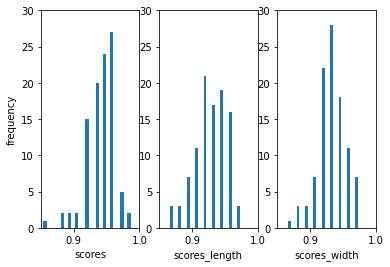

In [266]:
# Plot the histograms to see the data distribution

bins = 25
data_x = (scores, scores_length, scores_width)
x_labels = ('scores', 'scores_length', 'scores_width')
xlims = [[0.85, 1]]*3
ylims = [[0, 30]]*3

for j, (x, xlim, ylim, x_label) in enumerate(zip(data_x, xlims, ylims, x_labels)):
    ax = plt.subplot(1, 3, j+1)
    ax.hist(np.reshape(x,(-1,1)), bins = bins)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(x_label)
    
ax = plt.subplot(1,3,1)
ax.set_ylabel('frequency');

Oops! Our data does not have a gaussian distibution! To take this into account, we must use Wilcoxon signed-rank test, with the help of scipy.stats.wilcoxon().

**Task:** Calculate the wilcoxon signed-rank test for the groups above. Draw a conclusion!

In [267]:
from scipy.stats import wilcoxon

print(wilcoxon(scores_length, scores_width))

WilcoxonResult(statistic=1448.0, pvalue=0.13010696808686215)


pvalue > 0.1 Hence we accept the Null Hypothesis of equal means, which concludes that we fail to find significant differences at p=0.1 

**Note:** The corresponding test for non-paired case is the Mann-Whitney U test (scipy.stats.mannwhitneyu)

### Feedback

That's it, we're done 👏🏼🍻

If you have any suggestions on how we could improve this session, please let us know in the following cell. What did you particularly like or dislike? Did you miss any contents?